# Load Packages


In [1]:
from pathlib import Path

import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import img_as_ubyte
from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage.transform import rotate

# Read data


In [2]:
# change this path to your data folder
data_path = Path("cwk-data/data/RESISTORS/")

In [3]:
images_paths = list(data_path.iterdir())

In [4]:
print(images_paths)

[WindowsPath('cwk-data/data/RESISTORS/RESISTORS-1.png'), WindowsPath('cwk-data/data/RESISTORS/RESISTORS-2.png'), WindowsPath('cwk-data/data/RESISTORS/RESISTORS-3.png')]


In [5]:
# read resistor images as RGB format
im1 = cv2.cvtColor(cv2.imread(str(images_paths[0])), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread(str(images_paths[1])), cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(cv2.imread(str(images_paths[2])), cv2.COLOR_BGR2RGB)

In [6]:
# read resistor images in grayscale format
im1_gray = cv2.imread(str(images_paths[0]), cv2.IMREAD_GRAYSCALE)
im2_gray = cv2.imread(str(images_paths[1]), cv2.IMREAD_GRAYSCALE)
im3_gray = cv2.imread(str(images_paths[2]), cv2.IMREAD_GRAYSCALE)

Plot the images (grayscale) to validate it's been loaded successfully:


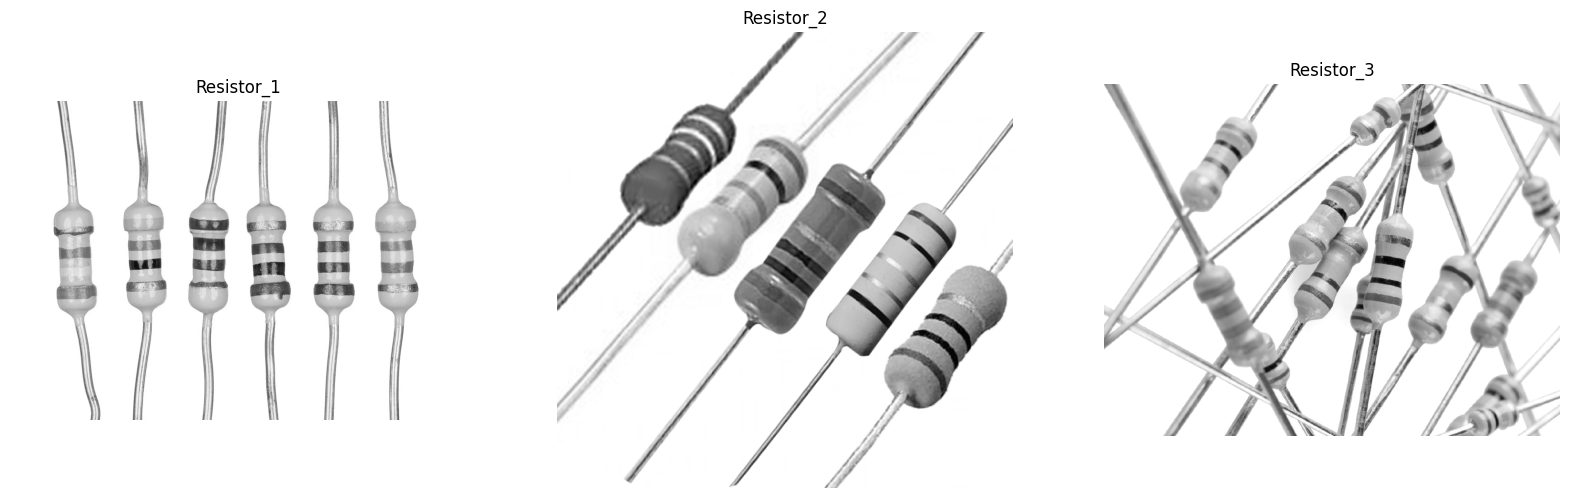

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))

for i, image in enumerate([im1_gray, im2_gray, im3_gray]):
    ax[i].imshow(image, cmap="gray")
    ax[i].set_title(f"Resistor_{i+ 1}")
    ax[i].axis("off")

# Image histogram


The image histogram is useful to find the distribution of pixel intensity values. This will allow us to later _threshold_ the image based on a specific intensity value.


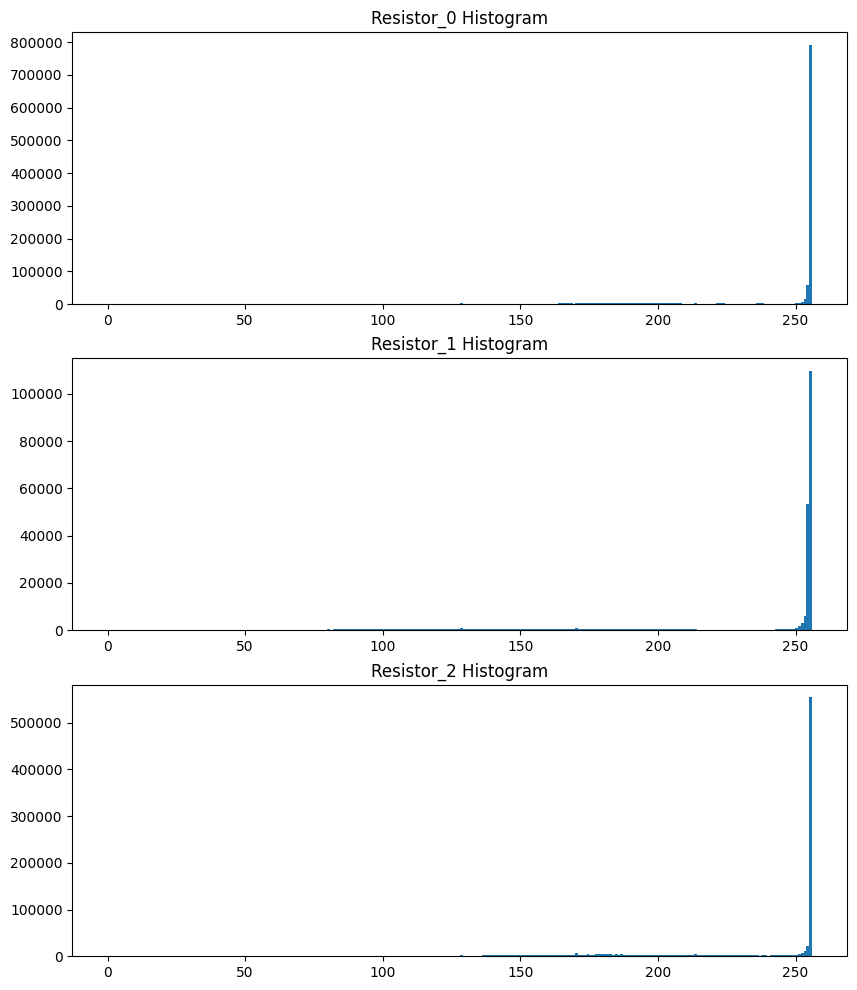

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

for i, image in enumerate([im1_gray, im2_gray, im3_gray]):
    ax[i].hist(image.ravel(), bins=250, range=[0, 256])
    ax[i].set_title(f"Resistor_{i} Histogram")

We can notice that the three histograms have single peak, which means the image can be separated into foreground and background based on a fixed value.


# Image binarization


From the previous histograms we noticed that a value above `200` will work well for segmenting the images. Here, we will try different threshold values and see which works the best:


In [9]:
def threshold_image(input_image: np.array, threshold_value: int):
    """
    Threshold an image based on `threshold_value`
    This function returns a binary image. For pixels < threshold_value, 1, otherwise it's 0
    """
    binary_image = np.zeros(input_image.shape, "int")
    binary_image[input_image < threshold_value] = 1

    return binary_image

In [10]:
thresholds = [100, 150, 200, 250]

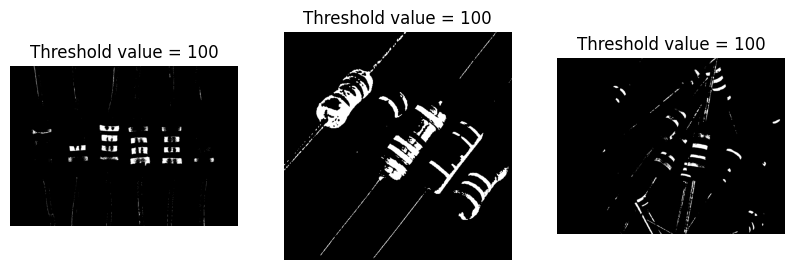

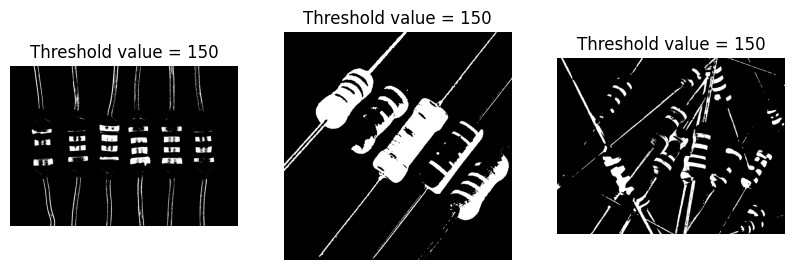

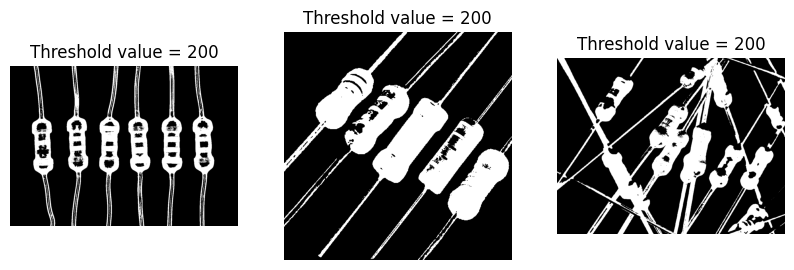

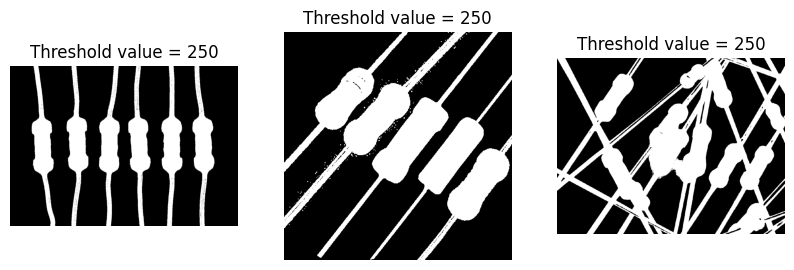

In [11]:
for threshold_val in thresholds:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

    im1_thresholded = threshold_image(im1_gray, threshold_val)
    im2_thresholded = threshold_image(im2_gray, threshold_val)
    im3_thresholded = threshold_image(im3_gray, threshold_val)

    ax[0].imshow(im1_thresholded, cmap="gray")
    ax[0].set_title(f"Threshold value = {threshold_val}")
    ax[0].axis("off")

    ax[1].imshow(im2_thresholded, cmap="gray")
    ax[1].set_title(f"Threshold value = {threshold_val}")
    ax[1].axis("off")

    ax[2].imshow(im3_thresholded, cmap="gray")
    ax[2].set_title(f"Threshold value = {threshold_val}")
    ax[2].axis("off")

    plt.show()

We can notice the for the first two images, value `250` is suitbale for separating the objects from the image.

The third image doesn't work.


# Connected components Analysis


After thresholding the images to identify the objects, we will calculate the components in each image to identify the locations of each resistor object separately. This will makes it easier to process a resistor and identiy its bands and colors.


In [12]:
# threshold the firts two images at 250
# the output is identical to the last row in the previous plot
im1_gray_thresholded = threshold_image(im1_gray, 250)
im2_gray_thresholded = threshold_image(im2_gray, 250)
# im3_gray_thresholded = threshold_image(im3_gray, 170)

Extract components from binary images using the `label` function:


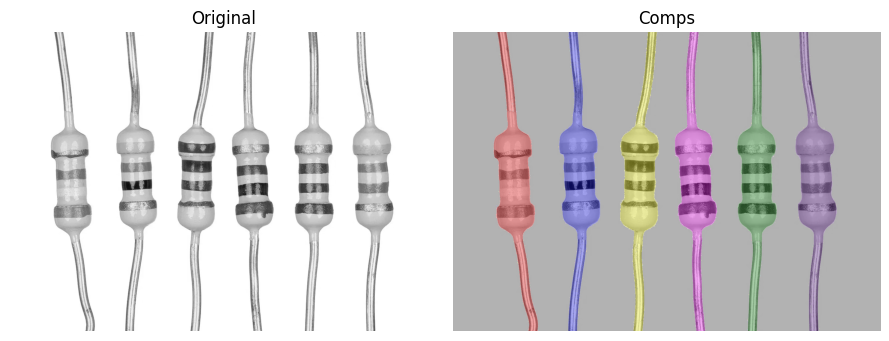

Number of componenets in the first image: (305,)
First few components with their sizes: 👇


,component_id,n_pixels
0,0,873987
1,1,45818
5,5,45670
3,3,45522
6,6,45444
2,2,45179
4,4,44783
54,54,6
217,217,6
166,166,5


In [13]:
im1_comps = label(im1_gray_thresholded, background=0)

# DataFrame containing the size (number of pixels) for each detected component
unique, counts = np.unique(im1_comps.flatten(), return_counts=True)
im1_comps_stats = pd.DataFrame(
    np.asarray((unique, counts)).T, columns=["component_id", "n_pixels"]
).sort_values(by="n_pixels", ascending=False)

color = label2rgb(im1_comps, image=im1_gray, bg_label=0)

fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(9, 5),
    sharex=True,
    sharey=True,
)

axes[0].imshow(im1_gray, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(color)
axes[1].set_title("Comps")
axes[1].axis("off")


fig.tight_layout()
plt.show()

print(f"Number of componenets in the first image: {np.unique(im1_comps).shape}")
print(f"First few components with their sizes: 👇")
display(im1_comps_stats[:10])

This information shows us that:

1. Componenet `0` is the background.
2. Componenets `1` through `6` are the resistors objects. Their area is about 45k pixels.
3. The rest of componenets have size of 2 or less. These are noise componenets and irrelevant to our detection.


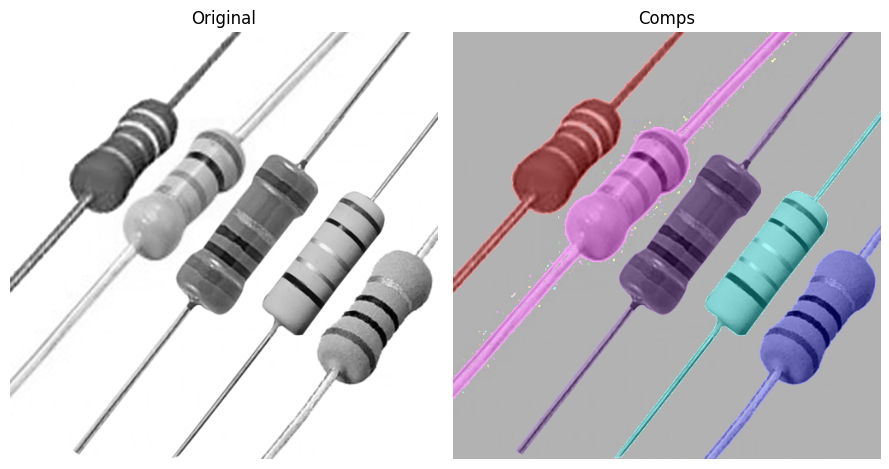

Number of componenets in the second image: (99,)
First few components with their sizes: 👇


,component_id,n_pixels
0,0,174730
4,4,18160
6,6,18008
52,52,13074
18,18,13049
1,1,12618
20,20,15
64,64,14
13,13,12
79,79,11


In [14]:
im2_comps = label(im2_gray_thresholded, background=0)

# DataFrame containing the size (number of pixels) for each detected component
unique, counts = np.unique(im2_comps.flatten(), return_counts=True)
im2_comps_stats = pd.DataFrame(
    np.asarray((unique, counts)).T, columns=["component_id", "n_pixels"]
).sort_values(by="n_pixels", ascending=False)

color = label2rgb(im2_comps, image=im2_gray, bg_label=0)

fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(9, 5),
    sharex=True,
    sharey=True,
)

axes[0].imshow(im2_gray, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(color)
axes[1].set_title("Comps")
axes[1].axis("off")

fig.tight_layout()
plt.show()

print(f"Number of componenets in the second image: {np.unique(im2_comps).shape}")
print(f"First few components with their sizes: 👇")
display(im2_comps_stats[:10])

Similar to the previous image, here also the component `0` is the background, and componenets `4`, `6`, `52`, `18`, and `1` are the resistors objects. The remaining componenets are irrelevant.


## Bounding box extraction


After calculating the componenets for the two images, we want to extract the actual object from the image. That is, we want to subselect the original image to select only the resistor object.

We will use the `regionprops` function which returns several important information from the componenets matrix. This information includes: the bounding box of the component, its center and orientation, its area, binary mask of the component, and so on.

The process that we will foloww is:

1. Select the bounding box for the component along with its mask. Here mask is boolean array for masking the component object.
2. Select the resistor object from the original image annd apply the mask to keep only the resistor object.
3. Rotate the resistor object to make it vertical.


In [15]:
def apply_mask(image, mask):
    """
    Apply boolean mask on image.
    Assign "white" color to pixels outside the mask. This is to ensure that the background is white
    """
    result = np.ones_like(image) * 255

    for i in range(3):
        result[mask, i] = image[mask, i]

    return result

In [16]:
im1_regions = regionprops(im1_comps)
im2_regions = regionprops(im2_comps)

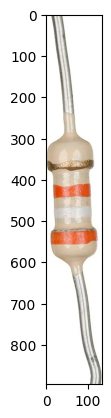

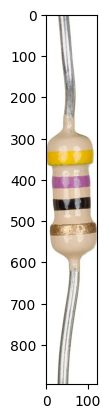

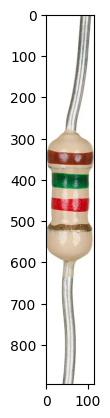

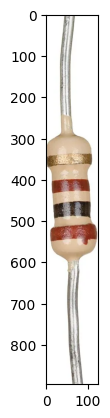

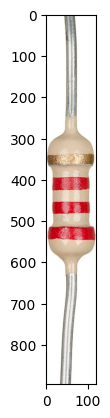

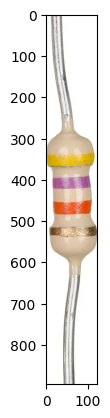

In [17]:
# list of resistor images from the first image
resistors_1 = []

# we get this from the im1_comps_stats DataFrame
min_area = 44783

for region in im1_regions:
    if int(region.area) >= min_area:
        # bounding box
        minr, minc, maxr, maxc = region.bbox
        resistor_blob = im1[minr:maxr, minc:maxc]
        resistor_mask = region.image_filled

        masked_image = apply_mask(resistor_blob, resistor_mask)

        resistors_1.append(masked_image)

        plt.imshow(resistor_blob)
        plt.show()

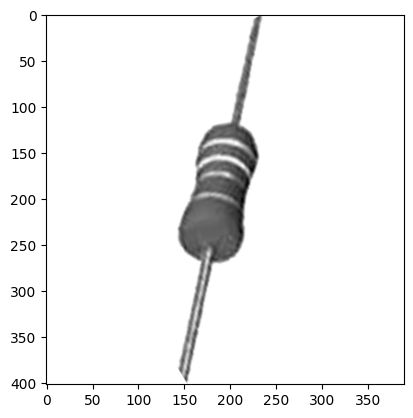

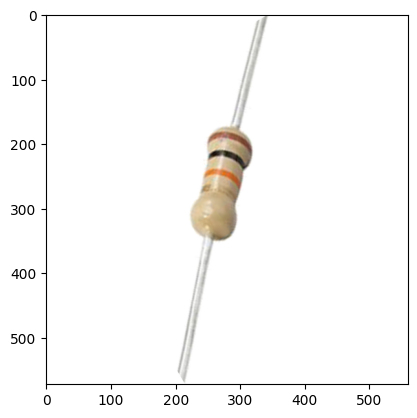

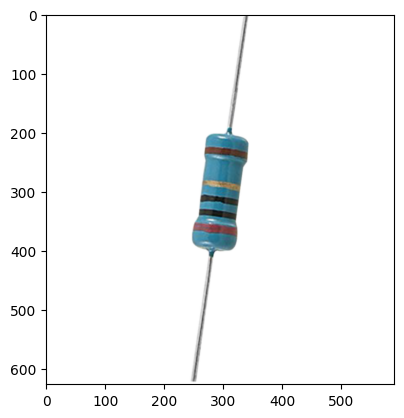

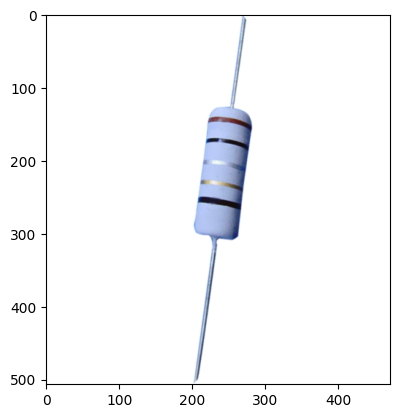

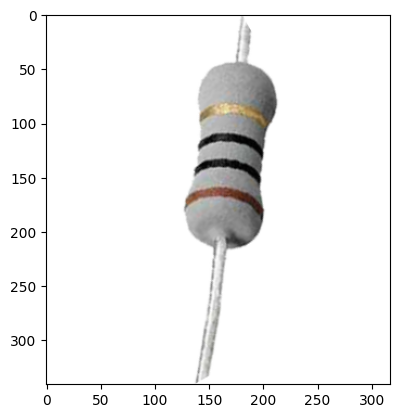

In [18]:
# list of resistor images from the second image
resistors_2 = []

# we get this from the im2_comps_stats DataFrame
min_area = 12618

for region in im2_regions:
    if int(region.area) >= min_area:
        minr, minc, maxr, maxc = region.bbox

        resistor_blob = im2[minr:maxr, minc:maxc]
        resistor_mask = region.image_filled

        # masking
        masked_image = apply_mask(resistor_blob, resistor_mask)

        # rotation
        rotated_image = rotate(
            masked_image,
            angle=30,
            resize=True,
            center=region.centroid,
            mode="constant",
            cval=1,
        )

        # the result of rotation is Float64.
        # img_as_ubyte casts the image to uint8
        resistors_2.append(img_as_ubyte(rotated_image))

        plt.imshow(rotated_image)
        plt.show()

# Color (or band) Detection


In [19]:
def detect_color(resistor_image: np.array, hue_low, hue_high):
    resistor_image_gray = cv2.cvtColor(resistor_image, cv2.COLOR_RGB2GRAY)
    resistor_image_hsv = cv2.cvtColor(resistor_image, cv2.COLOR_RGB2HSV)

    if type(hue_low) == int:
        color_mask = (resistor_image_hsv[:, :, 0] >= hue_low) & (
            resistor_image_hsv[:, :, 0] <= hue_high
        )

    else:
        color_mask = cv2.inRange(resistor_image_hsv, hue_low, hue_high)

    binarized_image = cv2.bitwise_and(
        resistor_image_gray, resistor_image_gray, mask=color_mask.astype("uint8")
    )

    kernel = np.ones((3, 3), np.uint8)

    closed_image = cv2.morphologyEx(binarized_image, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(
        closed_image,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE,
    )

    if len(contours) == 0:
        return None

    largest_contour = max(contours, key=cv2.contourArea)
    good_contours = [
        cv2.boundingRect(contour)
        for contour in contours
        if cv2.contourArea(contour) > 300
    ]

    if len(good_contours) != 0:
        return good_contours
    else:
        return None

In [20]:
def plot_resistor_bands(resistor_image: np.array, rectangles):
    fig, ax = plt.subplots()

    ax.imshow(resistor_image)

    for x, y, w, h in rectangles:
        rect = patches.Rectangle(
            (x, y), w, h, linewidth=1, edgecolor="r", facecolor="none"
        )

        ax.add_patch(rect)

    plt.show()

In [21]:
color_hsv_ranges = {
    "violet": [150, 160],
    "yellow": [20, 25],
    "orange": [5, 10],
    "brown": [np.array([5, 60, 20]), np.array([10, 255, 200])],
    "green": [68, 77],
    "red": [175, 179],
    # "white": [],
    # "gold": [],
    # "black": []
}

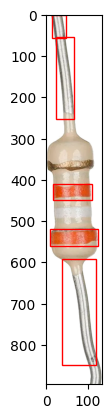

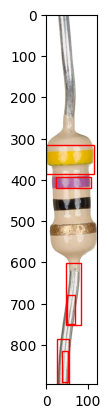

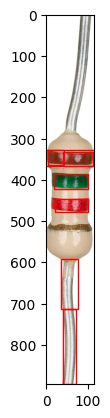

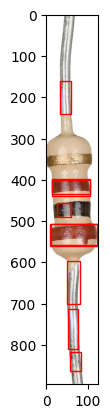

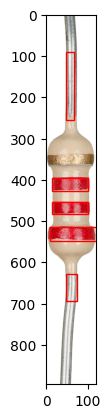

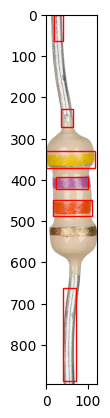

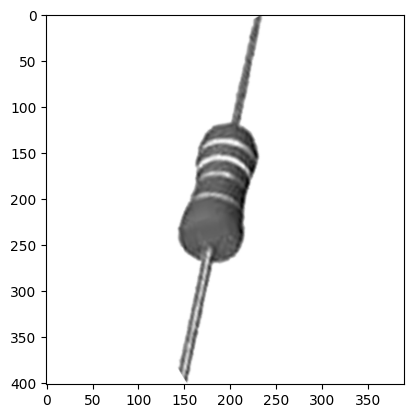

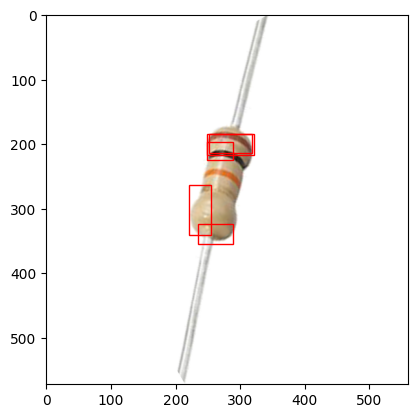

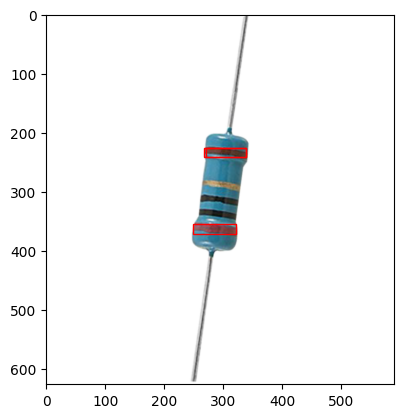

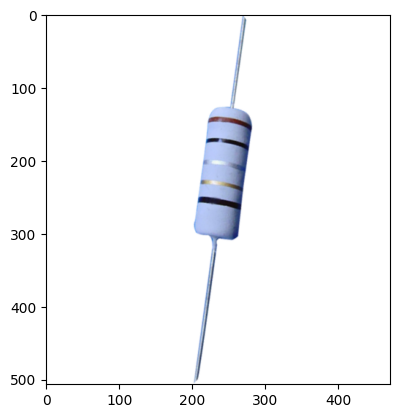

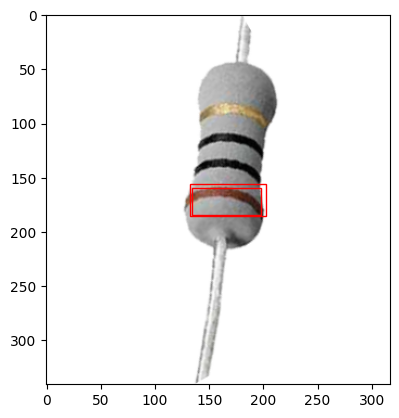

In [22]:
for resistor_image in resistors_1 + resistors_2:
    current_resistor_bands = []

    for color in color_hsv_ranges.keys():
        low, high = color_hsv_ranges[color]
        result = detect_color(resistor_image, low, high)

        if result is not None:
            current_resistor_bands.extend(result)

    if len(current_resistor_bands) != 0:
        plot_resistor_bands(resistor_image, current_resistor_bands)
    else:
        plot_resistor_bands(resistor_image, [])

One possible improvement to the code is to get rid of the silver thin lines as they are being detected although they are not actual bands.
